In [4]:
"""
Aime:Building a risk score model for retinopathy 
in diabetes patients using logistic regression
"""

#Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#Load Data

X = pd.read_csv('/content/X_data.csv', index_col=0)
y = pd.read_csv('/content/y_data.csv', index_col=0)

In [ ]:
X.head()

In [ ]:
y.head()

In [6]:
#Spliting tha data into train and test sets using 75/25 split

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

In [ ]:
for col in X.columns:
  X_train_raw.loc[:, col].hist()
  plt.title(col)
  plt.show()

In [31]:
#Mean-Normalize the Data
"""
    As you can see data has skew. one way to remove the skew is by adding log
    function to data.
    Many statistical models assume that the data is normally distributed.
    We need to transform our data so that its distribution is close to normal distribution.
    First we will remove some of the skew from the distribution by using the log transformation.
    Then we will "standardize" the distribution so that it has a mean of zero and standard deviation of 1.
    Equation: st_data = (x-mean)/std
"""

def make_standard_normal(df_train, df_test):

#Removing skew
  df_train_unskewed = np.log(df_train)
  df_test_unskewed = np.log(df_test)

#Calculating mean and std for train data
  mean = df_train_unskewed.mean(axis = 0)
  std  = df_train_unskewed.std(axis = 0)

#Standardizing  data
  standardized_train_data = (df_train_unskewed - mean)/std
  standardized_test_data = (df_test_unskewed - mean)/std

  return standardized_train_data, standardized_test_data

In [32]:
#Standardize data
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

In [ ]:
for col in X_train.columns:
  X_train.loc[:, col].hist()
  plt.title(col)
  plt.show()

In [33]:
#Make a logistic regression model
def lr_model(X_train, y_train):
  from sklearn.linear_model import LogisticRegression
  model = LogisticRegression()
  model.fit(X_train, y_train, sample_weight = None)
  return model

In [34]:
model_x =lr_model(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
#Evaluate the Model Using the C-index
"""
  The c-index measures the discriminatory power of a risk score.
  c-index = (concordant + 0.5*ties)/permissible
"""
def c_index(y_true, score):

  n = len(y_true)
  assert len(score) == n

  concordant  = 0
  ties        = 0
  permissible = 0

  for i in range(n):
    for j in range(i+1, n):
      if y_true[i] != y_true[j]:
        permissible +=1

        if score[i] == score[j]:
          ties += 1
          continue

        if y_true[i]==0 and y_true[j]==1:
          if score[i] < score[j]:
            concordant += 1

        if y_true[i]==1 and y_true[j]==0:
          if score[i] > score[j]:
            concordant += 1

  c_index = (concordant + (0.5 * ties)) / permissible
  return c_index

In [36]:
#Evaluate model on test set
"""
  predict_proba method will return the result from the model before
  it is converted to a binary 0 or 1.
  For each input case, it returns an array of two values which represent
  the probabilities for both the negative case and positive case.
"""

score = model_x.predict_proba(X_test)[:,1]
c_index_x_test = c_index(y_test.values, score)
print(f"c-index is {c_index_x_test:.4f}")

c-index is 0.8182


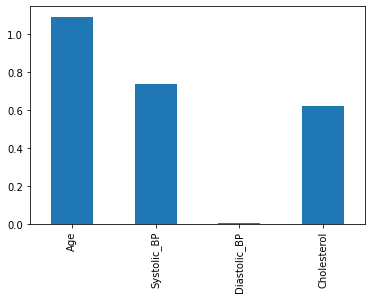

In [38]:
#Get coefficients of the model and see which of them has a big effect
coefs = pd.DataFrame(data = model_x.coef_ , columns= X_train.columns)
coefs.T.plot.bar(legend=None)

In [43]:
#Improving results 
"""
  by adding interaction we can improve results
"""
def add_interactions(X):

  features = X.columns
  m = len(features)
  x_int = X.copy(deep=True)

  for i in range(m):

    feature_i_name = features[i]
    feature_i_value = X.loc[:, feature_i_name]

    for j in range(i+1, m):

      feature_j_name = features[j]
      feature_j_value = X.loc[:, feature_j_name]

      feature_i_j_name = f'{feature_i_name}_X_{feature_j_name}'
      x_int[feature_i_j_name] = feature_i_value * feature_j_value

  return x_int

In [44]:
#interaction

X_train_int = add_interactions(X_train)
X_test_int  = add_interactions(X_test)

In [48]:
X_train_int.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol,Age_X_Systolic_BP,Age_X_Diastolic_BP,Age_X_Cholesterol,Systolic_BP_X_Diastolic_BP,Systolic_BP_X_Cholesterol,Diastolic_BP_X_Cholesterol
1824,-0.912451,-0.068019,-0.711482,0.574241,0.062064,0.649192,-0.523967,0.048394,-0.039059,-0.408562
253,-0.302039,1.719538,1.003758,-0.340915,-0.519367,-0.303174,0.102970,1.726001,-0.586217,-0.342197
1114,2.576274,0.155962,-0.018015,-1.051717,0.401800,-0.046412,-2.709511,-0.002810,-0.164027,0.018947
3220,1.163621,-2.033931,-0.748005,-2.065059,-2.366725,-0.870395,-2.402946,1.521391,4.200186,1.544675
2108,-0.446238,-0.054554,1.565538,0.073092,0.024344,-0.698603,-0.032617,-0.085407,-0.003987,0.114429


In [50]:
#train and test interactions

model_int = lr_model(X_train_int, y_train)
score = model_int.predict_proba(X_test_int)[:, 1]
int_c_index = c_index(y_test.values, score)
print(f"interactions c-index is {int_c_index:.4f}")

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


interactions c-index is 0.8281


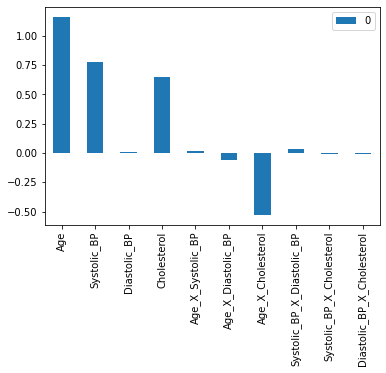

In [52]:
#get coefficients of the model
int_coef = pd.DataFrame(data = model_int.coef_ , columns = X_train_int.columns)
int_coef.T.plot.bar()